# CNN 구현

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [30]:
# 1. 데이터 입출력
# 데이터 전처리 (Normalization)
transform = transforms.Compose([transforms.RandomHorizontalFlip(),  # 데이터 증강 : 이미지 좌우 반전
                                # 데이터 증강 : padding 4를 하여 32 * 32 -> 40 * 40으로 변환한 뒤 랜덤 크롭 (패딩을 적용한 다음 32 * 32 사이즈로 랜덤 크롭)
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),  # 텐서로 변환
                                # 정규화 [(RGB평균),(RGB표준편차)]
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# CIFAR-10 데이터 로드
# 10개의 클래스로 구성된 32*32 60000개 컬러 이미지
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100,
                          shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100,
                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # conv 2번 / pooling 2번 / ReLU 1번
        self.conv_Layers = nn.Sequential(
            # 32 - 5 + 1 -> 28 => 32 * 32를 28 * 28 * 6 사이즈로 변환
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # stride -> 28 * 28 => 14 * 14
            nn.Conv2d(6, 16, 5),  # 14 - 5 + 1 = 10 -> 14 * 14 => 10 * 10
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # stride -> 10 * 10 => 5 * 5
        )
        self.flatten = nn.Flatten()
        self.fc_layer = nn.Sequential(
            nn.Linear(5*5*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )  # fully connected layer

    def forward(self, x):
        out = self.conv_Layers(x)
        flatten = self.flatten(out)
        fc_out = self.fc_layer(flatten)
        return fc_out


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv_Layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [34]:
# 손실함수 정의
loss_fn = nn.CrossEntropyLoss()
# # 가중치 학습1
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 가중치 학습2
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# 가중치 학습3
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [35]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 학습률 스케줄러 업데이트
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

print("학습 완료")

# 테스트하기
correct = 0
total = len(test_loader.dataset)
with torch.no_grad():  # test는 기울기 계산 X
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

Epoch 1, Loss: 2.0438124833106994
Epoch 2, Loss: 1.6787917845249176
Epoch 3, Loss: 1.5156420574188232
Epoch 4, Loss: 1.4239084050655364
Epoch 5, Loss: 1.359402225971222
Epoch 6, Loss: 1.3112263448238373
Epoch 7, Loss: 1.2774288144111634
Epoch 8, Loss: 1.2396995251178742
Epoch 9, Loss: 1.221140730381012
Epoch 10, Loss: 1.1888652169704437
학습 완료
Accuracy: 58.11%


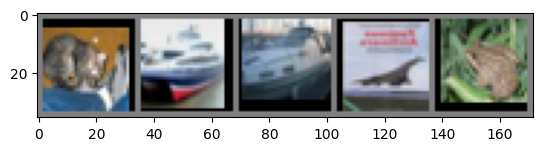

Predicted:  dog ship ship ship frog


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize, 0~1범위의 이미지를 -1~1의 범위로 사용했기 때문에 -0.5 -> *2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 이미지 차원 변경 torch (채널, 높이, 너비) -> plt (높이, 너비, 채널)
    plt.show()

def visualize_predictions(model, test_loader, num_images=5):
    dataiter = iter(test_loader)
    images, labels = next(dataiter) # 첫번째 배치의 이미지만 가져오기

    # 이미지 출력
    imshow(torchvision.utils.make_grid(images[:num_images]))

    # 모델 예측
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

    # 레이블 정의
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # 예측 결과 출력
    print("Predicted: ", " ".join(classes[predicted[j]] for j in range(num_images)))

visualize_predictions(model, test_loader, num_images=5)